In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Libraries

In [2]:
! pip install simple_colors

In [3]:
# Import the required Libraries
import numpy as np
import math
from osgeo import gdal
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches
from skimage import exposure
from skimage.io import imread, imshow,imsave
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
from tensorflow.python.keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import pandas as pd
from prettytable import PrettyTable
from keras import callbacks
import time
from pycocotools import mask
from skimage import measure
import cv2
from sklearn.model_selection import train_test_split
from decimal import *
from matplotlib.colors import ListedColormap,to_rgb
from matplotlib.patches import Patch
from keras.metrics import MeanIoU
import sklearn
from prettytable import PrettyTable
import simple_colors
import scipy.io
import random

### Read path & Load the datasets

In [4]:
#Set file directory of the location where the data is stored:
#train, validation  & test folder:
train_folder_PATH='/content/drive/MyDrive/Geo_Hoosh_W10_P1/train/'
val_folder_PATH='/content/drive/MyDrive/Geo_Hoosh_W10_P1/val/'

In [5]:
def readdata(directory, folder_name):

    data_path = os.path.join(directory, folder_name)
    data_list = {}
    for f in tqdm(sorted(os.listdir(data_path))):
        fdir = os.path.join(data_path, f)
        _, ext = os.path.splitext(f)
        if ext.lower() == ".tif":
            imgtype = f[-18:-4] # Number of characters of the image file. Example, "Image_1.tif" = 11 characters
            image_data=gdal.Open(fdir)
            bands = [image_data.GetRasterBand(i+1).ReadAsArray() for i in range(image_data.RasterCount)]
            data_list[imgtype] = np.stack(bands, axis=2)

    return data_list

In [6]:
#Read data:
train_im_list = readdata(directory=train_folder_PATH, folder_name="images")
train_label_list=readdata(directory=train_folder_PATH, folder_name="masks")

val_im_list = readdata(directory=val_folder_PATH, folder_name="images")
val_label_list=readdata(directory=val_folder_PATH, folder_name="masks")


<ipython-input-5-35a83e987273>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for f in tqdm(sorted(os.listdir(data_path))):


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

In [7]:
#Check If Everything Works (CIEW)
print("Number of train image & Label: " + str(len(train_im_list)))
print("Number of validation image &  Label: " + str(len(val_im_list)))

Number of train image & Label: 246
Number of validation image &  Label: 82


###Visualising the Datasets(train/val,test)

In [8]:
def visualize_ImLa(data,mask):
    f, axarr = plt.subplots(1,2,figsize = (10, 10))
    axarr[0].set_axis_off()
    data = data[:,:,:3]
    axarr[0].imshow(data)
    axarr[0].set_title("Original RGB Image",fontsize=10,color='red')

    a=axarr[1]
    values = np.unique(mask.ravel())
    plt.axis('off')

    colors = ['black' ,'white']
    cmap = ListedColormap(colors)
    legend_labels={'black' :'Background (non-building)','white':'Building'}

    patches = [Patch(color=color, label=label) for color, label in legend_labels.items()]
    plt.legend(handles=patches,bbox_to_anchor=(1.43,1),facecolor="wheat")
    im = axarr[1].imshow(mask,cmap=cmap)
    axarr[1].set_title("Ground Truth Damage Map",fontsize=10,color='red')

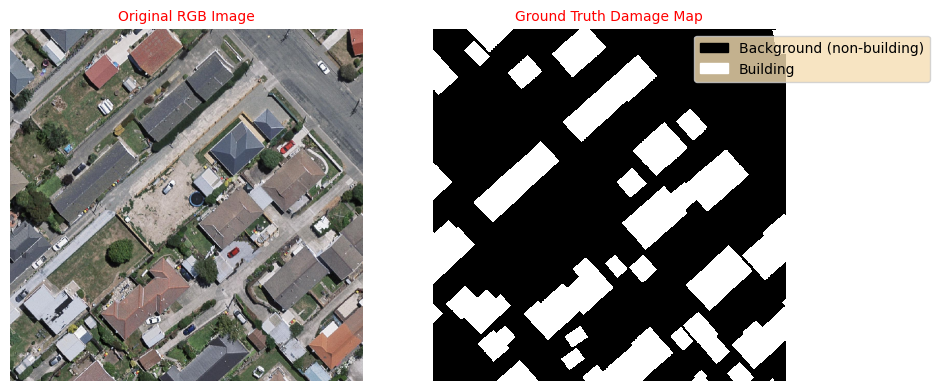

In [9]:
##visualizing  train/val image & label :
img_num = random.choice(list(train_im_list))
visualize_ImLa(train_im_list[img_num], train_label_list[img_num])

In [10]:
# FOR GENERATING TRAINING & Testing Patching:
NoTr=len(train_im_list) #Number of train image as input to patching
NoVa=len(val_im_list) #Number of validation image as input to patching
NBANDS =3
Patch_size=512

Xtrain = np.zeros(shape=(0, Patch_size,Patch_size, NBANDS), dtype=np.uint8)
Ytrain = np.zeros(shape=(0, Patch_size,Patch_size, 1), dtype=np.uint8)

Xval = np.zeros(shape=(0, Patch_size,Patch_size, NBANDS), dtype=np.uint8)
Yval = np.zeros(shape=(0, Patch_size,Patch_size, 1), dtype=np.uint8)

for S in list(train_im_list) :
    X_toadd = np.expand_dims(train_im_list[S],axis=0)
    Y_toadd = np.expand_dims(train_label_list[S],axis=0)
    Xtrain = np.concatenate((Xtrain, X_toadd), axis=0)
    Ytrain = np.concatenate((Ytrain, Y_toadd), axis=0)

for V in list(val_im_list) :
    X_toadd2 = np.expand_dims(val_im_list[V],axis=0)
    Y_toadd2 = np.expand_dims(val_label_list[V],axis=0)
    Xval = np.concatenate((Xval, X_toadd2), axis=0)
    Yval = np.concatenate((Yval, Y_toadd2), axis=0)

print('Shape of Training data', np.shape(Xtrain))
print('Shape of Validation data', np.shape(Xval))

Shape of Training data (246, 512, 512, 3)
Shape of Validation data (82, 512, 512, 3)


###Data Augmentation

In [12]:
# Data(Train) Augmentation:
#Reverse the order of elements along axis 1 (left/right).
X_train = np.append(Xtrain, [np.fliplr(x) for x in tqdm(Xtrain)], axis=0)
Y_train = np.append(Ytrain, [np.fliplr(x) for x in tqdm(Ytrain)], axis=0)

#Reverse the order of elements along axis 0 (up/down).
X_train = np.append(X_train, [np.flipud(x) for x in tqdm(Xtrain)], axis=0)
Y_train = np.append(Y_train, [np.flipud(x) for x in tqdm(Ytrain)], axis=0)

#Rotate an array by 90 degrees in the plane specified by axes.
X_train = np.append(X_train, [np.rot90(x) for x in tqdm(Xtrain)], axis=0)
Y_train = np.append(Y_train, [np.rot90(x) for x in tqdm(Ytrain)], axis=0)


print("Number of training patches after Augmentation: " + str(len(X_train)))
print("Shape of the image: "+ str(X_train[1].shape))
print("Number of training label  after Augmentation: " + str(len(Y_train)))
print("Shape of the image: "+ str(Y_train[1].shape))

<ipython-input-12-adab6f78bdc8>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  X_train = np.append(Xtrain, [np.fliplr(x) for x in tqdm(Xtrain)], axis=0)


  0%|          | 0/246 [00:00<?, ?it/s]

<ipython-input-12-adab6f78bdc8>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  Y_train = np.append(Ytrain, [np.fliplr(x) for x in tqdm(Ytrain)], axis=0)


  0%|          | 0/246 [00:00<?, ?it/s]

<ipython-input-12-adab6f78bdc8>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  X_train = np.append(X_train, [np.flipud(x) for x in tqdm(Xtrain)], axis=0)


  0%|          | 0/246 [00:00<?, ?it/s]

<ipython-input-12-adab6f78bdc8>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  Y_train = np.append(Y_train, [np.flipud(x) for x in tqdm(Ytrain)], axis=0)


  0%|          | 0/246 [00:00<?, ?it/s]

<ipython-input-12-adab6f78bdc8>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  X_train = np.append(X_train, [np.rot90(x) for x in tqdm(Xtrain)], axis=0)


  0%|          | 0/246 [00:00<?, ?it/s]

<ipython-input-12-adab6f78bdc8>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  Y_train = np.append(Y_train, [np.rot90(x) for x in tqdm(Ytrain)], axis=0)


  0%|          | 0/246 [00:00<?, ?it/s]

Number of training patches after Augmentation: 984
Shape of the image: (512, 512, 3)
Number of training label  after Augmentation: 984
Shape of the image: (512, 512, 1)


###Spliting of Test and Validation data

In [21]:
# split of train and validation data:
# X_val, X_test, Y_val, Y_test = train_test_split(Xval, Yval, test_size=0.3, random_state=42)

X_test=Xval[0:10]
Y_test=Yval[0:10]

X_val=Xval[10:83]
Y_val=Yval[10:83]


print("Number of validation patches after spliting: " + str(len(X_val)))
print("Number of testing after spliting: " + str(len(X_test)))

Number of validation patches after spliting: 72
Number of testing after spliting: 10


###Metrics for pixel-based quatitatively evaluation

In [11]:
def accuracy(y_true, y_pred, threshold=0.5):
    """compute accuracy"""
    y_pred = K.round(y_pred +0.5 - threshold)
    return K.equal(K.round(y_true), K.round(y_pred))

# K.round() returns the Element-wise rounding to the closest integer!!!
# So the threshold to determine a true positive is set here!!!!!
def true_positives(y_true, y_pred, threshold=0.5):
    """compute true positive"""
    y_pred = K.round(y_pred +0.5 - threshold)
    return K.round(y_true * y_pred)

def false_positives(y_true, y_pred, threshold=0.5):
    """compute false positive"""
    y_pred = K.round(y_pred +0.5 - threshold)
    return K.round((1 - y_true) * y_pred)

def true_negatives(y_true, y_pred, threshold=0.5):
    """compute true negative"""
    y_pred = K.round(y_pred +0.5 - threshold)
    return K.round((1 - y_true) * (1 - y_pred))

def false_negatives(y_true, y_pred, threshold=0.5):
    """compute false negative"""
    y_pred = K.round(y_pred +0.5 - threshold)
    return K.round((y_true) * (1 - y_pred))

def OA(y_true, y_pred):
  tp = true_positives(y_true, y_pred)
  tn = true_negatives(y_true, y_pred)
  fn = false_negatives(y_true, y_pred)
  fp = false_positives(y_true, y_pred)
  OA=(K.sum(tp) + K.sum(tn))/(K.sum(tp) + K.sum(fn) + K.sum(fp) + K.sum(tn) + K.epsilon())
  return OA

def recall_m(y_true, y_pred):
    tp = true_positives(y_true, y_pred)
    fn = false_negatives(y_true, y_pred)
    recall = K.sum(tp) / (K.sum(tp) + K.sum(fn)+ K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    tp = true_positives(y_true, y_pred)
    fp = false_positives(y_true, y_pred)
    precision = K.sum(tp) / (K.sum(tp) + K.sum(fp)+ K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def K_C(y_true, y_pred):
  tp = true_positives(y_true, y_pred)
  tn = true_negatives(y_true, y_pred)
  fn = false_negatives(y_true, y_pred)
  fp = false_positives(y_true, y_pred)
  Nt=K.sum(tp)+K.sum(fn) + K.sum(fp) + K.sum(tn) +K.epsilon()
  Po=(K.sum(tp)+K.sum(tn))/Nt
  Pe=(((K.sum(tp)+K.sum(fn))*(K.sum(tp)+K.sum(fn)))/Nt**2) + (((K.sum(fn)+K.sum(tn))*(K.sum(fp)+K.sum(tn)))/Nt**2)
  K_C=(((Po-Pe))/(1-Pe))*100
  return K_C

  # Define IoU metric
def iou(y_true, y_pred,smooth= 1e-15):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

### Functions for visualization results

In [12]:
def Tensor_to_array_Desimal(Tens) :
  tf.compat.v1.disable_eager_execution()
  arr=np.float64(Tens.eval(session=tf.compat.v1.Session()))
  arr_desi=Decimal(arr).quantize(Decimal('0.01'), rounding=ROUND_HALF_UP)
  return arr_desi

In [13]:
def VisPredict_Truth(Img, GT, Pred) :
  # p,k,l = Pred.shape
  # Pred_r=Pred.reshape(p*k,l)
  # GT_r=GT.reshape(p*k,l)


  plt.figure(figsize=(15,30))
  plt.subplot(131)
  plt.imshow(Img[:,:,:3])
  plt.title("Original Image",fontsize=7,color='red')
  plt.axis('off')

  plt.subplot(132)
  colors = ['black' ,'white']
  cmap = ListedColormap(colors)
  legend_labels={'black' :'Background (non-building)','white':'Building'}
  patches = [Patch(color=color, label=label) for color, label in legend_labels.items()]
  plt.legend(handles=patches,bbox_to_anchor=(1.2,1),facecolor="wheat",fontsize=8)
  plt.imshow(GT,cmap=cmap)
  plt.title("Ground Truth Image",fontsize=7,color='red')
  plt.axis('off')

  plt.subplot(133)
  patches = [Patch(color=color, label=label) for color, label in legend_labels.items()]
  plt.legend(handles=patches,bbox_to_anchor=(1.2,1),facecolor="wheat", fontsize=8)
  plt.imshow(Pred,cmap=cmap)
  plt.title("Predicted Image ",fontsize=7,color='red')
  plt.axis('off')

  t = PrettyTable(['OA','K_C','IoU','Precision','Recall','F1-score'])
  t.add_row([Tensor_to_array_Desimal(OA(GT, Pred)*100),
             Tensor_to_array_Desimal(K_C(GT, Pred)),
             Tensor_to_array_Desimal(iou(GT, Pred)*100),
             Tensor_to_array_Desimal(precision_m(GT, Pred)*100),
             Tensor_to_array_Desimal(recall_m(GT, Pred)*100),
             Tensor_to_array_Desimal(f1_m(GT, Pred)*100)])
  print(simple_colors.blue(str(t),'bold'))

###Set Hyper-parameters, General Settings and Callbacks

In [14]:
# Checkpoint for saving the weights
checkpoint_path = os.path.join('/content/drive/MyDrive/Weights_U-Net','weights.{epoch:02d}-{loss:.2f}.hdf5')

# Create a callback that saves the model's weights at every epoch
callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True, save_best_only=False, monitor="val_loss", mode = "min",
                                                 verbose=1)

# Create a callback to reduce the learning rate using the ReduceLROnPlateau function
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.33, patience=5, mode="min")

#Finding the optimal number of epochs to avoid overfitting
earlystopping = callbacks.EarlyStopping(monitor ="loss",
                                        mode ="min", patience = 5,
                                        restore_best_weights = True)


# Compile the checkpoints and other settings as a callback
callback_list = [callback,reduce_lr, earlystopping]

In [15]:
# Set of optimizers
lr = 0.0001
delta = tf.keras.optimizers.Adadelta(learning_rate=1, rho=0.95, epsilon=1e-7)
adam = tf.keras.optimizers.Adam(learning_rate=lr)
sgd = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0, nesterov=False, name='SGD')


optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
# optimizer = adam #Change between "adam" or "delta" or "sgd"


##State1: Base-U-Net

### Design conv-blocks

In [22]:
#convolutional block
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid
from keras import models, layers, regularizers
from keras import backend as K
from keras.regularizers import l2

def conv_block(x, kernelsize, filters, dropout, batchnorm=True):
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    return conv

### Design Main architecture

In [23]:
#U-NET
def unet(input_shape=(512,512,3), dropout=0.1, batchnorm=True):

    filters = [16, 32, 64, 128, 256]
    kernelsize = 3

    inputs = layers.Input(input_shape)

    # Downsampling layers (encode path)
    dn_1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)

    dn_2 = conv_block(pool1, kernelsize, filters[1], dropout, batchnorm)
    pool2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)

    dn_3 = conv_block(pool2, kernelsize, filters[2], dropout, batchnorm)
    pool3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)

    dn_4 = conv_block(pool3, kernelsize, filters[3], dropout, batchnorm)
    pool4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)

    dn_5 = conv_block(pool4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers (decode path)
    up_5=Conv2DTranspose(filters[3], (kernelsize, kernelsize), strides=2, padding="same")(dn_5)
    up_5 = layers.concatenate([up_5, dn_4], axis=3)
    up_conv_5 = conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)

    up_4=Conv2DTranspose(filters[2], (kernelsize, kernelsize), strides=2, padding="same")(up_conv_5)
    up_4 = layers.concatenate([up_4, dn_3], axis=3)
    up_conv_4 =conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)

    up_3=Conv2DTranspose(filters[1], (kernelsize, kernelsize), strides=2, padding="same")(up_conv_4)
    up_3 = layers.concatenate([up_3, dn_2], axis=3)
    up_conv_3 =conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)

    up_2=Conv2DTranspose(filters[0], (kernelsize, kernelsize), strides=2, padding="same")(up_conv_3)
    up_2 = layers.concatenate([up_2, dn_1], axis=3)
    up_conv_2 = conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)

    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='accuracy')
    print(model.summary())
    return model

In [24]:
model=unet()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 16)         0         ['batch_normalization[0][0

### Train U-Net

In [25]:
from datetime import datetime
start1=datetime.now()
results = model.fit(X_train, Y_train,
                    batch_size=12,
                    epochs=100,
                    validation_data=(X_val,Y_val),
                    callbacks = callback_list)
stop1=datetime.now()
execution_time=stop1-start1
print('U_net execution time is: ',execution_time)

Epoch 1/100
82/82 [==============================] - ETA: 0s - loss: 0.6103 - accuracy: 0.6958
Epoch 1: saving model to /content/drive/MyDrive/Weights_U-Net/weights.01-0.61.hdf5
82/82 [==============================] - 84s 751ms/step - loss: 0.6103 - accuracy: 0.6958 - val_loss: 3.6472 - val_accuracy: 0.2787 - lr: 1.0000e-04
Epoch 2/100
82/82 [==============================] - ETA: 0s - loss: 0.4905 - accuracy: 0.8492
Epoch 2: saving model to /content/drive/MyDrive/Weights_U-Net/weights.02-0.49.hdf5
82/82 [==============================] - 60s 733ms/step - loss: 0.4905 - accuracy: 0.8492 - val_loss: 0.8039 - val_accuracy: 0.6213 - lr: 1.0000e-04
Epoch 3/100
82/82 [==============================] - ETA: 0s - loss: 0.4581 - accuracy: 0.8952
Epoch 3: saving model to /content/drive/MyDrive/Weights_U-Net/weights.03-0.46.hdf5
82/82 [==============================] - 60s 737ms/step - loss: 0.4581 - accuracy: 0.8952 - val_loss: 0.4829 - val_accuracy: 0.8665 - lr: 1.0000e-04
Epoch 4/100
82/82 [

In [26]:
np.save('/content/drive/MyDrive/Unet_history.npy',results.history)

In [27]:
history=np.load('/content/drive/MyDrive/Unet_history.npy',allow_pickle='TRUE').item()

In [ ]:
import pandas as pd
# # convert array into dataframe
DF = pd.DataFrame(history)

# # save the dataframe as a csv file
DF.to_csv("Unet_history.csv")

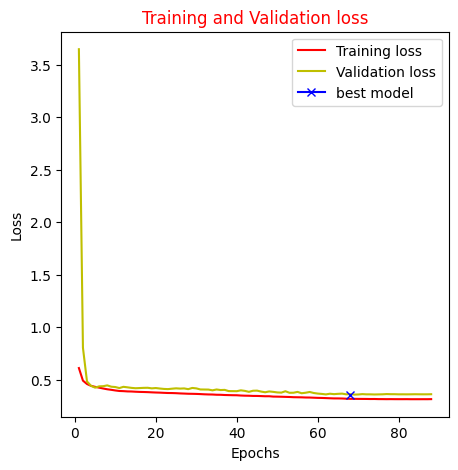

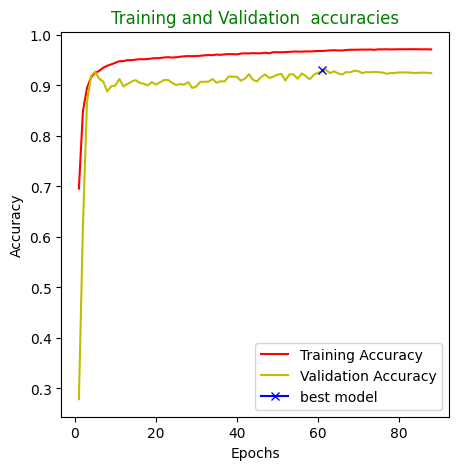

In [28]:
#training-validation loss curve
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)


plt.figure(figsize=(5,5))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.plot(np.argmin(history["val_loss"]), np.min(history["val_loss"]), marker="x", color="b", label="best model")
plt.title('Training and Validation loss',fontname="Brush Script MT",color="red")
plt.xlabel('Epochs',fontname="Gabriola")
plt.ylabel('Loss')
plt.legend()
# plt.savefig('/content/drive/MyDrive/DARU_Net_Training loss.png',dpi=300)
plt.show()


#training-validation accuracy curve
acc = history['accuracy']
val_acc = history['val_accuracy']
plt.figure(figsize=(5,5))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation Accuracy')
plt.plot(np.argmax(history["val_accuracy"]), np.max(history["val_accuracy"]), marker="x", color="b", label="best model")
plt.title('Training and Validation  accuracies',color="green")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('/content/drive/MyDrive/DARU_Net_Training accuracies.png',dpi=300)
plt.show()

In [29]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,val_loss,val_accuracy,lr
68,0.316994,0.970733,0.357589,0.929264,0.000011
69,0.316432,0.970848,0.358645,0.928231,0.000011
73,0.315558,0.970645,0.358690,0.926900,0.000011
74,0.314484,0.971614,0.359445,0.926297,0.000004
61,0.324139,0.968803,0.359454,0.930857,0.000033
...,...,...,...,...,...
3,0.440795,0.915919,0.440708,0.918489,0.000100
7,0.408172,0.939140,0.445285,0.888239,0.000100
2,0.458149,0.895238,0.482897,0.866511,0.000100
1,0.490497,0.849155,0.803921,0.621318,0.000100


### Load Model

In [ ]:
model.load_weights('/content/drive/MyDrive/Weights_2/weights.25-0.36.hdf5')

In [34]:
preds_test = model.predict(X_test, verbose=1)
preds_test = (preds_test>0.5)

1/1 [==============================] - 0s 128ms/step


### Evaluation

In [36]:
def _as_tf_output(self):
  raise NotImplementedError(
        "_as_tf_output not supported when eager execution is enabled.")

def eval(self, feed_dict=None, session=None):
  raise NotImplementedError(
        "eval is not supported when eager execution is enabled, "
        "is .numpy() what you're looking for?")

+-------+-------+-------+-----------+--------+----------+
|   OA  |  K_C  |  IoU  | Precision | Recall | F1-score |
+-------+-------+-------+-----------+--------+----------+
| 96.09 | 90.45 | 87.23 |   93.06   | 93.30  |  93.18   |
+-------+-------+-------+-----------+--------+----------+


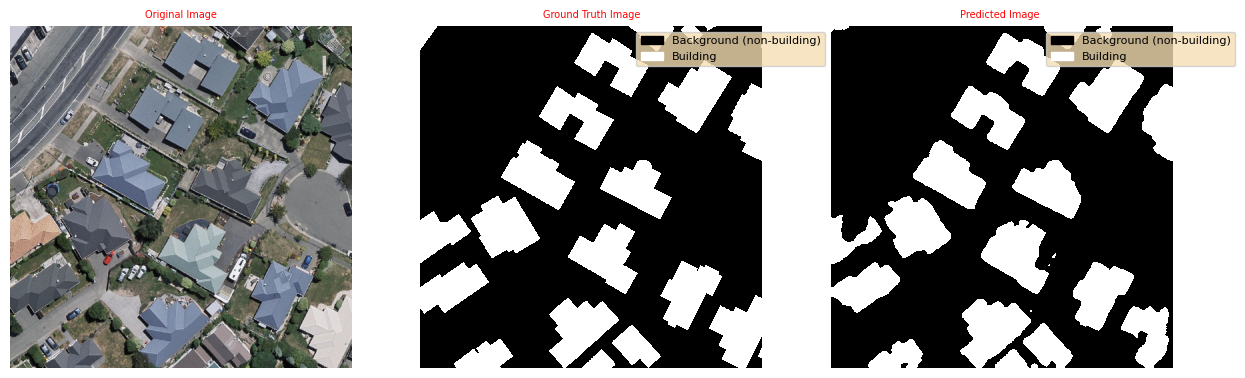

In [38]:
import secrets
values = list(range(10))
R_V=secrets.choice(values)
img=list(val_im_list)[R_V]
lab=list(val_label_list)[R_V]

VisPredict_Truth(val_im_list[img], val_label_list[lab] ,preds_test[R_V])

##State2: ResU-Net

### Design residual convolutional block

In [16]:
#convolutional block
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid
from keras import models, layers, regularizers
from keras import backend as K
from keras.regularizers import l2

def res_conv_block(x, kernelsize, filters, dropout, batchnorm=False):
    conv1 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        conv1 = layers.BatchNormalization(axis=3)(conv1)
    conv1 = layers.Activation('relu')(conv1)
    conv2 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(conv1)
    if batchnorm is True:
        conv2 = layers.BatchNormalization(axis=3)(conv2)
        conv2 = layers.Activation("relu")(conv2)
    if dropout > 0:
        conv2 = layers.Dropout(dropout)(conv2)

    #skip connection
    shortcut = layers.Conv2D(filters, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)
    shortcut = layers.Activation("relu")(shortcut)
    respath = layers.add([shortcut, conv2])
    return respath

### Design Main architecture

In [17]:
#Residual-Attention UNET (RA-UNET)
def residual_unet(input_shape=(512,512,3), dropout=0.2, batchnorm=True):

    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2

    inputs = layers.Input(input_shape)

    # Downsampling layers (encode path)
    dn_1 = res_conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)

    dn_2 = res_conv_block(pool1, kernelsize, filters[1], dropout, batchnorm)
    pool2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)

    dn_3 = res_conv_block(pool2, kernelsize, filters[2], dropout, batchnorm)
    pool3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)

    dn_4 = res_conv_block(pool3, kernelsize, filters[3], dropout, batchnorm)
    pool4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)

    dn_5 = res_conv_block(pool4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers (decode path)
    up_5=Conv2DTranspose(filters[3], (kernelsize, kernelsize), strides=2, padding="same")(dn_5)
    up_5 = layers.concatenate([up_5, dn_4], axis=3)
    up_conv_5 = res_conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)

    up_4=Conv2DTranspose(filters[2], (kernelsize, kernelsize), strides=2, padding="same")(up_conv_5)
    up_4 = layers.concatenate([up_4, dn_3], axis=3)
    up_conv_4 = res_conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)

    up_3=Conv2DTranspose(filters[1], (kernelsize, kernelsize), strides=2, padding="same")(up_conv_4)
    up_3 = layers.concatenate([up_3, dn_2], axis=3)
    up_conv_3 = res_conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)

    up_2=Conv2DTranspose(filters[0], (kernelsize, kernelsize), strides=2, padding="same")(up_conv_3)
    up_2 = layers.concatenate([up_2, dn_1], axis=3)
    up_conv_2 = res_conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)

    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='accuracy')
    print(model.summary())
    return model

In [18]:
model=residual_unet()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 16)         0         ['batch_normalization[0][0

### Train ResU-Net

In [ ]:
from datetime import datetime
start1=datetime.now()
results = model.fit(X_train, Y_train,
                    batch_size=12,
                    epochs=100,
                    validation_data=(X_val,Y_val),
                    callbacks = callback_list)
stop1=datetime.now()
execution_time=stop1-start1
print('U_net execution time is: ',execution_time)

Epoch 1/100
82/82 [==============================] - ETA: 0s - loss: 0.6103 - accuracy: 0.6958
Epoch 1: saving model to /content/drive/MyDrive/Weights_U-Net/weights.01-0.61.hdf5
82/82 [==============================] - 84s 751ms/step - loss: 0.6103 - accuracy: 0.6958 - val_loss: 3.6472 - val_accuracy: 0.2787 - lr: 1.0000e-04
Epoch 2/100
82/82 [==============================] - ETA: 0s - loss: 0.4905 - accuracy: 0.8492
Epoch 2: saving model to /content/drive/MyDrive/Weights_U-Net/weights.02-0.49.hdf5
82/82 [==============================] - 60s 733ms/step - loss: 0.4905 - accuracy: 0.8492 - val_loss: 0.8039 - val_accuracy: 0.6213 - lr: 1.0000e-04
Epoch 3/100
82/82 [==============================] - ETA: 0s - loss: 0.4581 - accuracy: 0.8952
Epoch 3: saving model to /content/drive/MyDrive/Weights_U-Net/weights.03-0.46.hdf5
82/82 [==============================] - 60s 737ms/step - loss: 0.4581 - accuracy: 0.8952 - val_loss: 0.4829 - val_accuracy: 0.8665 - lr: 1.0000e-04
Epoch 4/100
82/82 [

In [ ]:
np.save('/content/drive/MyDrive/Unet_history.npy',results.history)

In [39]:
history=np.load('/content/drive/MyDrive/ResUnet_history.npy',allow_pickle='TRUE').item()

In [ ]:
import pandas as pd
# # convert array into dataframe
DF = pd.DataFrame(history)

# # save the dataframe as a csv file
DF.to_csv("Unet_history.csv")

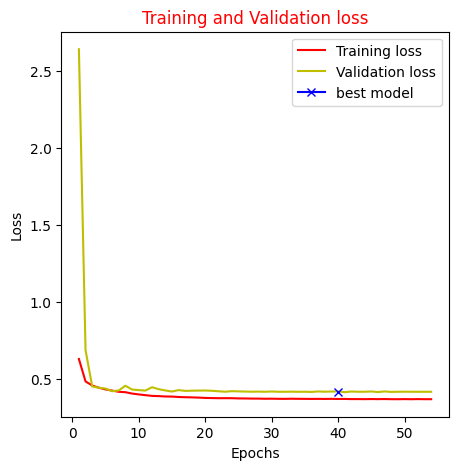

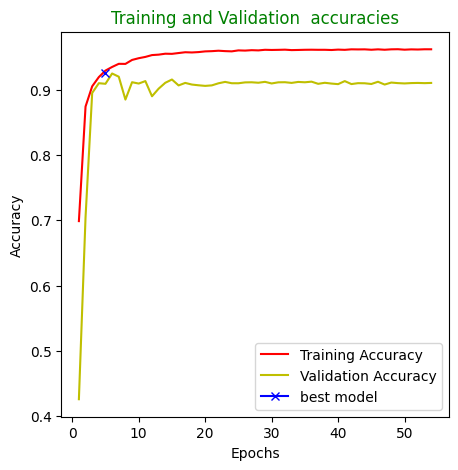

In [40]:
#training-validation loss curve
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)


plt.figure(figsize=(5,5))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.plot(np.argmin(history["val_loss"]), np.min(history["val_loss"]), marker="x", color="b", label="best model")
plt.title('Training and Validation loss',fontname="Brush Script MT",color="red")
plt.xlabel('Epochs',fontname="Gabriola")
plt.ylabel('Loss')
plt.legend()
# plt.savefig('/content/drive/MyDrive/DARU_Net_Training loss.png',dpi=300)
plt.show()


#training-validation accuracy curve
acc = history['accuracy']
val_acc = history['val_accuracy']
plt.figure(figsize=(5,5))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation Accuracy')
plt.plot(np.argmax(history["val_accuracy"]), np.max(history["val_accuracy"]), marker="x", color="b", label="best model")
plt.title('Training and Validation  accuracies',color="green")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('/content/drive/MyDrive/DARU_Net_Training accuracies.png',dpi=300)
plt.show()

In [41]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,val_loss,val_accuracy,lr
68,0.316994,0.970733,0.357589,0.929264,0.000011
69,0.316432,0.970848,0.358645,0.928231,0.000011
73,0.315558,0.970645,0.358690,0.926900,0.000011
74,0.314484,0.971614,0.359445,0.926297,0.000004
61,0.324139,0.968803,0.359454,0.930857,0.000033
...,...,...,...,...,...
3,0.440795,0.915919,0.440708,0.918489,0.000100
7,0.408172,0.939140,0.445285,0.888239,0.000100
2,0.458149,0.895238,0.482897,0.866511,0.000100
1,0.490497,0.849155,0.803921,0.621318,0.000100


### Load Model

In [19]:
model.load_weights('/content/drive/MyDrive/Weights_ResU-Net/weights.54-0.37.hdf5')

In [22]:
preds_test = model.predict(X_test, verbose=1)
preds_test = (preds_test>0.5)

1/1 [==============================] - 13s 13s/step


### Evaluation

In [26]:
def _as_tf_output(self):
  raise NotImplementedError(
        "_as_tf_output not supported when eager execution is enabled.")

def eval(self, feed_dict=None, session=None):
  raise NotImplementedError(
        "eval is not supported when eager execution is enabled, "
        "is .numpy() what you're looking for?")

+-------+-------+-------+-----------+--------+----------+
|   OA  |  K_C  |  IoU  | Precision | Recall | F1-score |
+-------+-------+-------+-----------+--------+----------+
| 92.17 | 79.40 | 74.37 |   92.23   | 79.33  |  85.30   |
+-------+-------+-------+-----------+--------+----------+


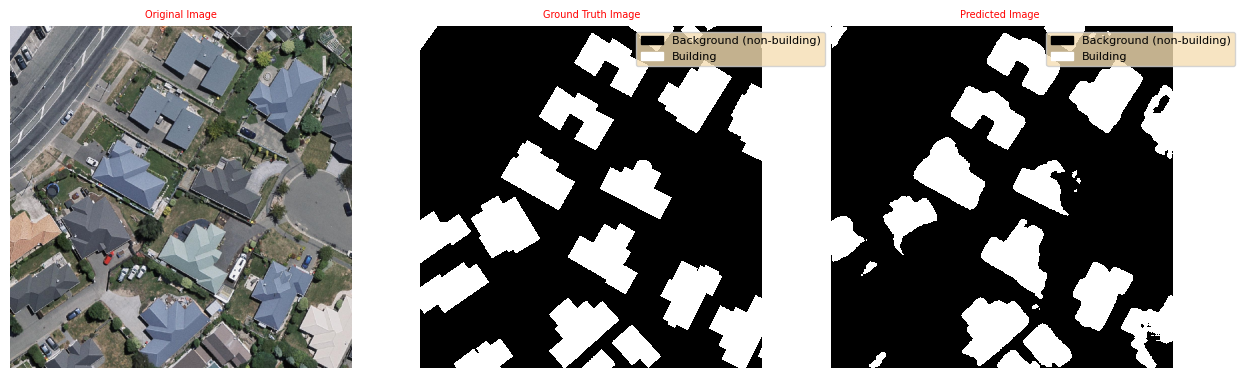

In [27]:
# import secrets
# values = list(range(10))
# R_V=secrets.choice(values)
R_V=9
img=list(val_im_list)[R_V]
lab=list(val_label_list)[R_V]

VisPredict_Truth(val_im_list[img], val_label_list[lab] ,preds_test[R_V])